In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'leapgestrecog:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39466%2F61155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T155534Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da61f6a1a051a2fc9a9da0bacd24a69fb96662b0ba70d63dd1e0882aef86c3756f032ae3fbb56a435d08635870a77726eb86e4239e09881e4dc870f8767ebb51bbaaefde4f5893cb7d94caa37cb2c7ae7d1e4ea8bc2b52d4c196c595c3a696f080b1202d2264078ed11e7a05a90b7ad67437ab5bd68ec35d153b674f3d679f323043cf82941e4ca8c4901e13f9fb064f0ca4ad84663fdfca5d78ffd6af864616e48dd95598e4bc224badd7012cd3fbf9b9b4f62bb8e585761d5d12622639633b69d8bdae0bd2ce0f835e9c80369601505a15356ac7470cf7792de1b0cf11547cf12450a1cc923881e903eff6c5bdd340c72e6ff5dc46b3f309d2dcdd92772e2b3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2286085038 bytes downloaded
Downloaded and uncompressed: leapgestrecog
Data source import complete.


# 1. Libraries

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# 2. Dataset

In [3]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

data_path = "../input/leapgestrecog/leapGestRecog"

In [4]:
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[ 5,  5,  7, ...,  5,  4,  5],
        [ 5,  7,  7, ...,  5,  4,  4],
        [ 7,  6,  9, ...,  4,  5,  3],
        ...,
        [19, 23, 32, ...,  5,  5,  4],
        [15, 23, 27, ...,  6,  5,  6],
        [16, 22, 26, ...,  4,  5,  6]], dtype=uint8),
 0]

# 3. Data Preprocessing

In [5]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

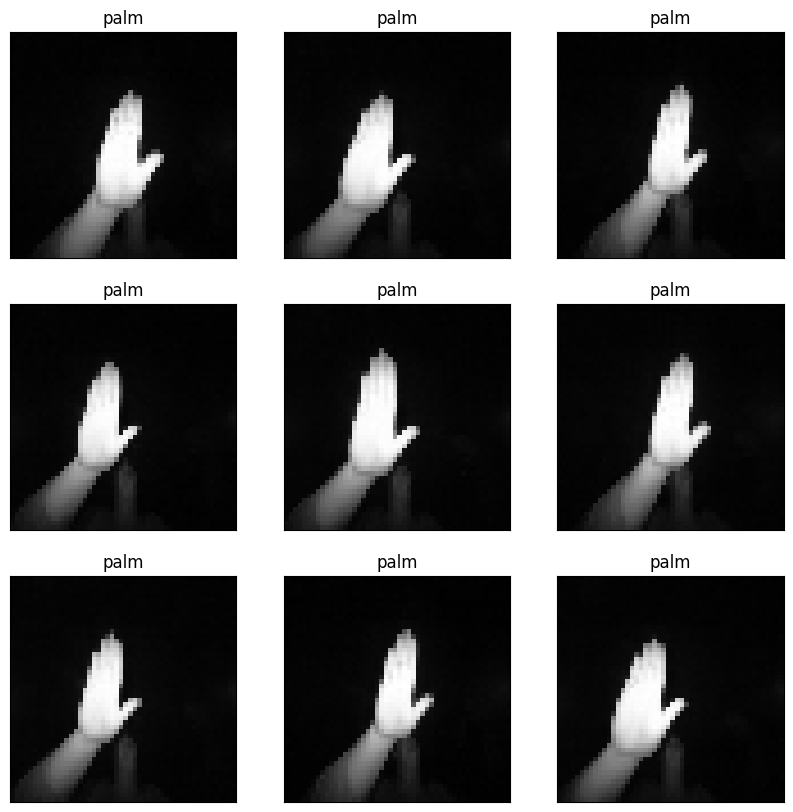

In [7]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [8]:
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [9]:
import keras
from keras.utils import to_categorical
label = to_categorical(label)

In [10]:
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

# 4. Built CNN Model & Train

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label,test_size=0.2, random_state=42, shuffle=True)

In [12]:
model = keras.models.Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

# 5. Model Performance

In [13]:
history = model.fit(X_train, y_train, epochs =4, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/4
500/500 [==============================] - 129s 253ms/step - loss: 0.2075 - accuracy: 0.9375 - val_loss: 0.0071 - val_accuracy: 0.9985
Epoch 2/4
500/500 [==============================] - 121s 242ms/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0056 - val_accuracy: 0.9985
Epoch 3/4
500/500 [==============================] - 113s 227ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0043 - val_accuracy: 0.9987
Epoch 4/4
500/500 [==============================] - 120s 241ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0046 - val_accuracy: 0.9990


# 6. Model Evaluation

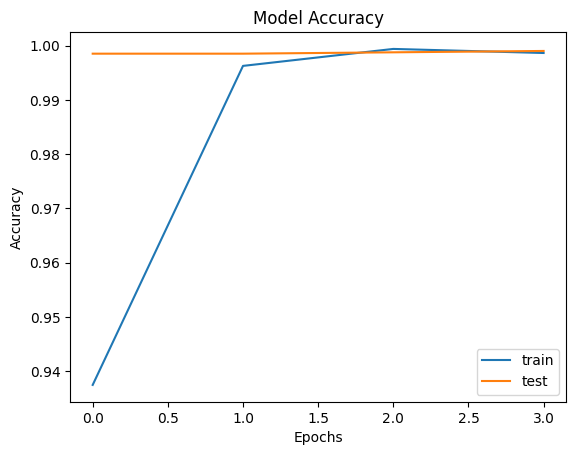

In [14]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

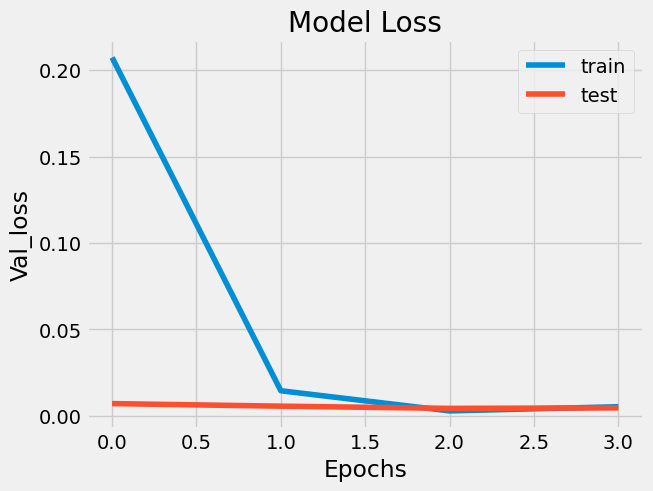

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Val_loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(test_accuracy*100))

125/125 [==============================] - 7s 58ms/step - loss: 0.0046 - accuracy: 0.9990
Test accuracy: 99.90%
